In [1]:
#import libraries
import pandas as pd
import numpy as np
import requests
import psycopg2
import re
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

### Function to create connection to our PostgreSQL database

In [2]:

# Function to create connection to our PostgreSQL database
def get_connection():
    """Function to create connection to our PostgreSQL database"""
    connection = psycopg2.connect(user = "postgres",
                                  password = 'hangnguyen',
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "tiki")
    return connection

### Create table product to hold information of all the products on tiki

In [ ]:
def create_table_product():
    """Create table product to hold information of all the products on tiki"""
    # get connection to PostgreSQL database using get_connection() function
    conn = get_connection()
    # create cursor
    cursor = conn.cursor()
    
    # create table
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Product
    (
        id INT,
        seller_id INT,
        title VARCHAR(700),
        brand VARCHAR(700),
        price FLOAT,
        discount INT,
        rating INT,
        tikinow INT,
        subcategory VARCHAR(500),
        category VARCHAR(500),
        image VARCHAR(700)
    )
    """)
    
    # save the change 
    conn.commit()

### Function to parse url to get the HTML code

In [3]:
#The third function parsers(url) will get the HTML code from the website, and return the parsed version of it, allowing us to pull data from it
def parseUrl(url):
    """Get a parsed version of url"""
    plain = requests.get(url).text
    
    # Parser. 
    # Hint: Use BeautifulSoup
    s = BeautifulSoup(plain,features="lxml")
    
    return s

### Get the URLs of all categories on Tiki homepage

In [4]:
# The fourth function get_urls() will get all the categories on tiki and the urls of those categories  
def get_urls():
    """Get the URLs of all categories on Tiki homepage"""
    
    url = 'https://tiki.vn/'
    # parse url
    s = parseUrl(url)

    # create an empty list to contain the name of all the categories with the url link to a specific product's page
    categories = []
    
    #Iterator through all the a tag which contains the information of each category and their url
    for i in s.find_all("a",class_ = "MenuItem__MenuLink-tii3xq-1 efuIbv"):
        # find the category's name
        cat = i.find_all("span",class_="text")[0].string
        # find the url of that category
        url = i.get("href")
        # append 
        categories.append((cat,url))
    
    return categories

### Scrape product's information on 1 page

In [25]:
# The final function
def scrape(cat,url):
    """Scrape product's information on 1 page"""
    # get connection to PostgreSQL database using get_connection() function
    conn = get_connection()
    # create cursor
    cursor = conn.cursor()
    
    # create a product list to hold the product's information of that page
    products = []

    # parse url using the parse function
    s = parseUrl(url)

    # find the div tag that contains information of each product on that page
    product_items = s.find_all("div",class_="product-item")

    # find the next page
    flag = 0
    urls = s.find_all("a",class_="normal")
    if len(s.find_all("span",class_="current"))!=0:
        curr = int(s.find_all("span",class_="current")[0].text)

        # Iterator through list of pages in that category
        for u in urls:
            # Check whether there is a link to the next page 
            if int(u.text) > int(curr):
                flag = 1
                next_url = "https://tiki.vn"+u.get("href")
                break

    if flag == 0:
        next_url = None
    # If that tag is empty (i.e. the page doesn't have any product), return an empty list.
    if len(product_items) == 0:
        return None

    # If that tag is not empty (i.e. the page has products),...
    else: 
        
        # Iterate through all product_items and store the product information in the 'row' list
        for i in range(len(product_items)):
        # The order of items in row is: 
        # data-id -> data-seller-product-id -> data-title -> data_brand -> data-price -> discount
        # rating -> tikinow  ->sub category -> cat (category) -> product-image
            # check whether the product is available for tikinow
            tikinow = 0
            if len(product_items[i].find_all("i",class_="icon-tikinow")) != 0:
                tikinow = 1
            
            # find the category of the product
            sub_cat = product_items[i]['data-category'].split("-")[0]
            
            # find the rating rate
            ratings = product_items[i].find_all("span",class_="rating-content")
            # If the product has rating then take only the rating percentage
            # Else asign the rating with np.nan
            if len(ratings) != 0:
                rating = int(ratings[0].span["style"].split(":")[1].split("%")[0])
            else:
                rating = None
                
            # find the rate of discount
            discount_tag_content = product_items[i].find_all("span",class_="sale-tag-square")[0].text
            if len(discount_tag_content)!=0:
                discount = int(re.findall("[0-9]+",discount_tag_content)[0])
            else:
                discount = None
                
            row_product = (product_items[i]['data-id'], 
                   product_items[i]['data-seller-product-id'], 
                   product_items[i]['data-title'],
                   product_items[i]['data-brand'],
                   product_items[i]['data-price'] if len(product_items[i]['data-price'])!=0 else None,
                   discount,
                   rating, 
                   tikinow, 
                   sub_cat,
                   cat,
                   product_items[i].a.img['src']
                          )
            cursor.execute("INSERT INTO Product VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)",row_product)
        
        conn.commit()
    conn.close()
    # Return the url of the next page
    return next_url


### Scrape all product on tiki 

In [19]:
def scrape_all():
    # create a queue that store the category's name and a link to their respective product page
    queue = [list(i) for i in get_urls()]

    while len(queue)!=0:
        # get the url link of the last item in queue
        url = queue[-1][1]
        
        # get the name of the category of the last item in the queue 
        cat = queue[-1][0]
        print('Scraping', cat)

        # pop the last item out of the queue
        queue = queue[:-1]
        
        # check whether the link exists or not
        if url != None:
            next_url = scrape(cat,url)
            # check whether the link to the next page exists or not
            if next_url:
                queue.append((cat,next_url))
                print('Add next page', next_url)


### Test function scrape_all()

In [26]:
scrape_all()

Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=2
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=3
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=4
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=5
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=6
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=7
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=8
Scraping Voucher - Dịch Vụ 

Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=61
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=62
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=63
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=64
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=65
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=66
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner&page=67
Scraping Voucher - Dịch Vụ - Thẻ Cào
Add next page https:

Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=25
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=26
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=27
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=28
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=29
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=30
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=31
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=3

Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=89
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=90
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=91
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=92
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=93
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=94
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=95
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=9

Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=153
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=154
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=155
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=156
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=157
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=158
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner&page=159
Scraping Sách, VPP & Quà Tặng
Add next page https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner

Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=9
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=10
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=11
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=12
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=13
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=14
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=15
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=16
Scraping Hàng quốc tế
Add next page https://tik

Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=77
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=78
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=79
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=80
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=81
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=82
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=83
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=84
Scraping Hàng quốc tế
Add next page https://ti

Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=144
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=145
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=146
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=147
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=148
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=149
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=150
Scraping Hàng quốc tế
Add next page https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner&page=151
Scraping Hàng quốc tế
Add next page ht

Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=3
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=4
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=5
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=6
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=7
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=8
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=9
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.ham

Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=65
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=66
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=67
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=68
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=69
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=70
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=71
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8

Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=126
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=127
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=128
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=129
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=130
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=131
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=132
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?

Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=187
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=188
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=189
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=190
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=191
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=192
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner&page=193
Scraping Xe Máy, Ô tô, Xe Đạp
Add next page https://tiki.vn/o-to-xe-may-xe-dap/c8594?

Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=41
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=42
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=43
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=44
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=45
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=46
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=47
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_m

Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=104
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=105
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=106
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=107
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=108
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=109
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=110
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamb

Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=166
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=167
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=168
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=169
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=170
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=171
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamburger_menu_fly_out_banner&page=172
Scraping Thể Thao - Dã Ngoại
Add next page https://tiki.vn/the-thao-da-ngoai/c1975?src=c.1975.hamb

Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=21
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=22
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=23
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=24
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=25
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=26
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=27
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=28
Scraping Thời trang - Phụ kiện


Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=87
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=88
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=89
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=90
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=91
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=92
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=93
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=94
Scraping Thời trang - Phụ kiện


Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=153
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=154
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=155
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=156
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=157
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=158
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=159
Scraping Thời trang - Phụ kiện
Add next page https://tiki.vn/thoi-trang/c914?src=c.914.hamburger_menu_fly_out_banner&page=160
Scraping Thời trang - P

Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=10
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=11
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=12
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=13
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=14
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=15
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=16
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_ban

Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=74
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=75
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=76
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=77
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=78
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=79
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=80
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_ban

Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=137
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=138
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=139
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=140
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=141
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=142
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=143
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_

Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=200
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=201
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=202
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=203
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=204
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=205
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner&page=206
Scraping Làm Đẹp - Sức Khỏe
Add next page https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_

Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=57
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=58
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=59
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=60
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=61
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=62
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=63
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=64
Scraping Đồ chơi, Mẹ & Bé


Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=123
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=124
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=125
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=126
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=127
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=128
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=129
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=130
Scraping Đồ chơi, 

Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=189
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=190
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=191
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=192
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=193
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=194
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=195
Scraping Đồ chơi, Mẹ & Bé
Add next page https://tiki.vn/do-choi-me-be/c2549?src=c.2549.hamburger_menu_fly_out_banner&page=196
Scraping Đồ chơi, 

Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=43
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=44
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=45
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=46
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=47
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=48
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=49
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-on

Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=103
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=104
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=105
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=106
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=107
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=108
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=109
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach

Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=163
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=164
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=165
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=166
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=167
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=168
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner&page=169
Scraping Hàng Tiêu Dùng - Thực Phẩm
Add next page https://tiki.vn/bach

Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=16
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=17
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=18
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=19
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=20
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=21
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=22
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=23
Sc

Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=81
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=82
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=83
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=84
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=85
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=86
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=87
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=88
Sc

Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=145
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=146
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=147
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=148
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=149
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=150
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=151
Scraping Nhà Cửa Đời Sống
Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&pag

Add next page https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner&page=209
Scraping Nhà Cửa Đời Sống
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=2
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=3
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=4
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=5
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=6
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=7
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=8
Scraping Điện Gia Dụng
A

Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=68
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=69
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=70
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=71
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=72
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=73
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=74
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=75
Scraping Điện Gia Dụng
Add next page https://ti

Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=135
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=136
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=137
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=138
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=139
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=140
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=141
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=142
Scraping Điện Gia Dụng
Add next page ht

Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=202
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=203
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=204
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=205
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=206
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=207
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=208
Scraping Điện Gia Dụng
Add next page https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner&page=209
Scraping Điện Gia Dụng
Scraping Máy Ảnh

Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=61
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=62
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=63
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=64
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=65
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=66
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=67
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=68
Scraping Máy Ảnh - Quay Phim
Add next page https://ti

Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=128
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=129
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=130
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=131
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=132
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=133
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=134
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=135
Scraping Máy Ảnh - Quay Phim
Add next page ht

Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=195
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=196
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=197
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=198
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=199
Scraping Máy Ảnh - Quay Phim
Add next page https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner&page=200
Scraping Máy Ảnh - Quay Phim
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=2
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_men

Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=54
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=55
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=56
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=57
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=58
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=59
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=60
Scraping Laptop - Thiế

Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=111
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=112
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=113
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=114
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=115
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=116
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=117
Scraping Laptop

Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=168
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=169
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=170
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=171
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=172
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=173
Scraping Laptop - Thiết bị IT
Add next page https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner&page=174
Scraping Laptop

Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=17
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=18
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=19
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=20
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=21
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=22
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=23
Scraping Phụ Kiện - Thiết Bị Số
Add ne

Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=75
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=76
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=77
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=78
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=79
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=80
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=81
Scraping Phụ Kiện - Thiết Bị Số
Add ne

Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=133
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=134
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=135
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=136
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=137
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=138
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=139
Scraping Phụ Kiện - Thiết Bị Số

Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=191
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=192
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=193
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=194
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=195
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=196
Scraping Phụ Kiện - Thiết Bị Số
Add next page https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner&page=197
Scraping Phụ Kiện - Thiết Bị Số

Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=44
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=45
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=46
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=47
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=48
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=49
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=50
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_m

Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=107
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=108
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=109
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=110
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=111
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=112
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamburger_menu_fly_out_banner&page=113
Scraping Điện Tử - Điện Lạnh
Add next page https://tiki.vn/dien-tu-dien-lanh/c4221?src=c.4221.hamb

### Select data from the product table in Postgres and put it into dataframe

In [3]:
def create_dataframe_products():
    """This function will select data from the product table in Postgres and put it into dataframe"""
    
    # get connection to tiki database in Postgres
    conn = get_connection()
    
    # create cursor
    cursor = conn.cursor()
    
    # select all of data in the product table
    cursor.execute("SELECT * FROM Product;")
    
    # create a list to hold the result of cursor
    arr = cursor.fetchall()
    
    # put the result in to dataframe
    df_products = pd.DataFrame(arr, columns = ['product_id', 
                                              'seller_id', 
                                              'title',
                                              'brand',
                                              'price',
                                              'discount', 
                                              'rating',
                                              'tikinow',
                                              'subcategory',
                                              'category', 
                                              'image' ]
                              )
    
    # close the connection
    conn.close()
    
    # return dataframe
    return df_products

### Test function create_dataframe_products()

In [4]:
products = create_dataframe_products()
products.tail()

,product_id,seller_id,title,brand,price,discount,rating,tikinow,subcategory,category,image
141036,3717703,3717707,Điện Thoại Di Động GSM ZONO N8110 2.4inch – Hà...,Zono,199000.0,62.0,50.0,1,Điện Thoại,Điện Thoại - Máy Tính Bảng,https://salt.tikicdn.com/cache/200x200/ts/prod...
141037,19845668,19846490,Xiaomi Redmi 7 (2G/16G) - Hàng chính hãng,Xiaomi,2920000.0,31.0,NaN,0,,Điện Thoại - Máy Tính Bảng,https://salt.tikicdn.com/cache/200x200/ts/prod...
141038,23228658,23228660,Điện Thoại Samsung Galaxy S8 (4GB / 64GB) - Bả...,Samsung,6390000.0,12.0,NaN,0,,Điện Thoại - Máy Tính Bảng,https://salt.tikicdn.com/cache/200x200/ts/prod...
141039,23105947,23105949,Điện Thoại Itel Alpha Lite - Hàng Chính Hãng,Itel,1050000.0,12.0,NaN,0,,Điện Thoại - Máy Tính Bảng,https://salt.tikicdn.com/cache/200x200/ts/prod...
141040,14380981,14380983,Điện Thoại Samsung Galaxy A80 (128GB/8GB) - Hà...,Samsung,14990000.0,NaN,NaN,0,Điện Thoại,Điện Thoại - Máy Tính Bảng,https://salt.tikicdn.com/cache/200x200/ts/prod...


<h1> Analysis

In [5]:
products["price"].describe()

count    1.410400e+05
mean     1.998086e+06
std      1.073567e+07
min      2.800000e+03
25%      9.900000e+04
50%      2.190000e+05
75%      7.070500e+05
max      6.490000e+08
Name: price, dtype: float64

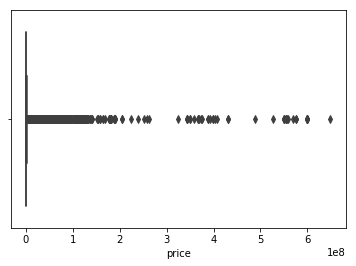

In [19]:
sns.boxplot(products["price"])

##### Since the price of some categories were much more higher than others, leading to outliers. So in order to make a correct analysis, separate price into category to see the distribution of each category

##### Which category has the highest mean price ? 

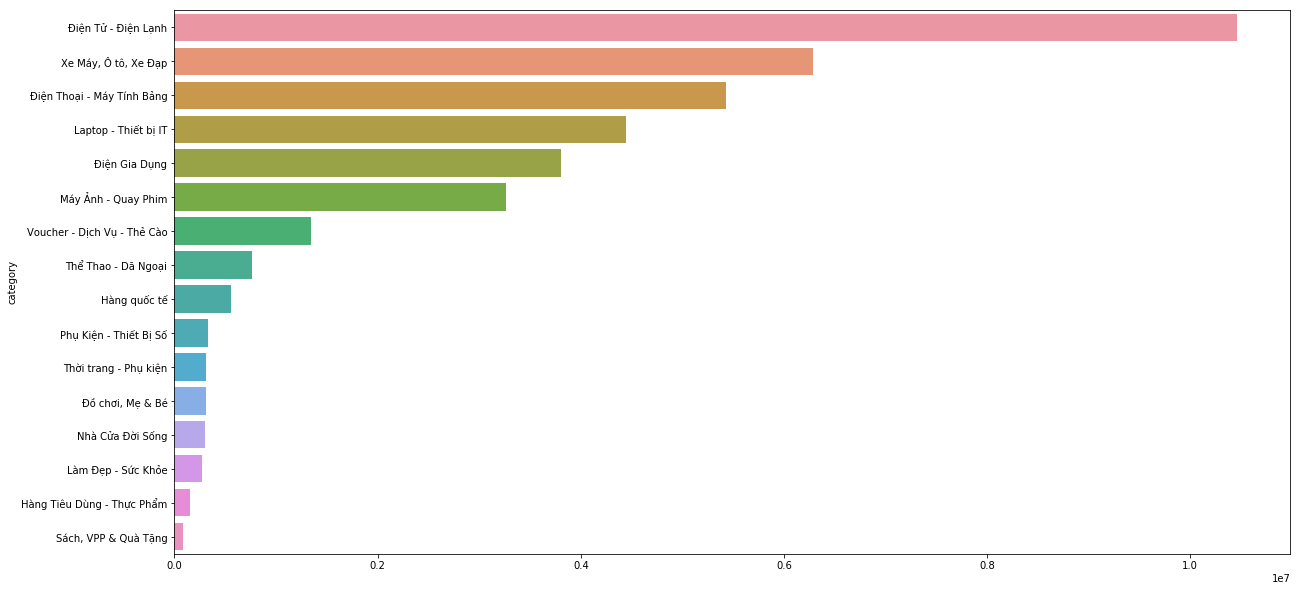

In [85]:
mean_price = products.groupby("category")["price"].mean().sort_values(ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(y = mean_price.index,x = mean_price.values)


#### What category has the highest rating ? 

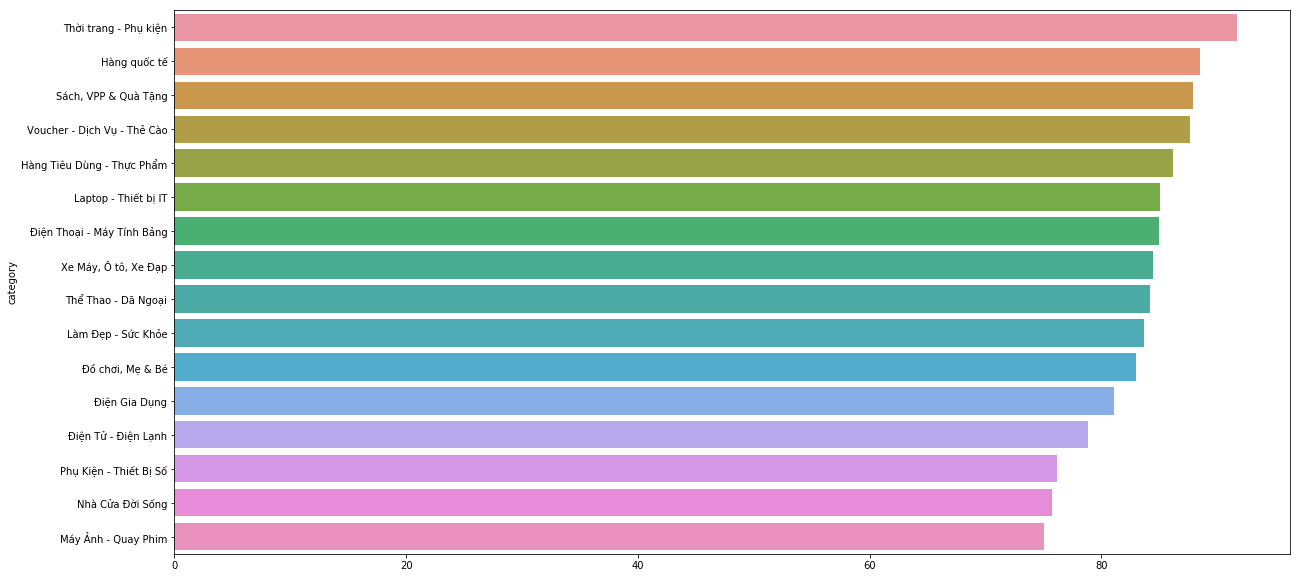

In [5]:
mean_rating = products.groupby("category")["rating"].mean().sort_values(ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(y = mean_rating.index,x = mean_rating.values)

In [89]:
categories = df["category"].unique()
categories.shape[0]

16

#### The distribution of price in phone and tablet category

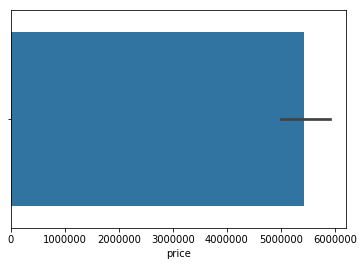

In [20]:
dienthoai = products[products["category"]=="Điện Thoại - Máy Tính Bảng"]
sns.barplot(dienthoai["price"])

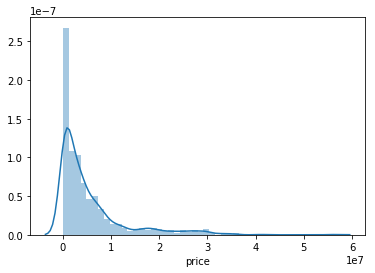

In [21]:
sns.distplot(dienthoai["price"])

#### Which brand has the highest price in phone and tablet category ?

In [11]:
def brand_price(df):
    mean_price = df.groupby(["brand","subcategory"])["price"].mean().sort_values(ascending=False).head(20)
    plt.figure(figsize=(20,30))
    sns.barplot(y = mean_price.index,x = mean_price.values)

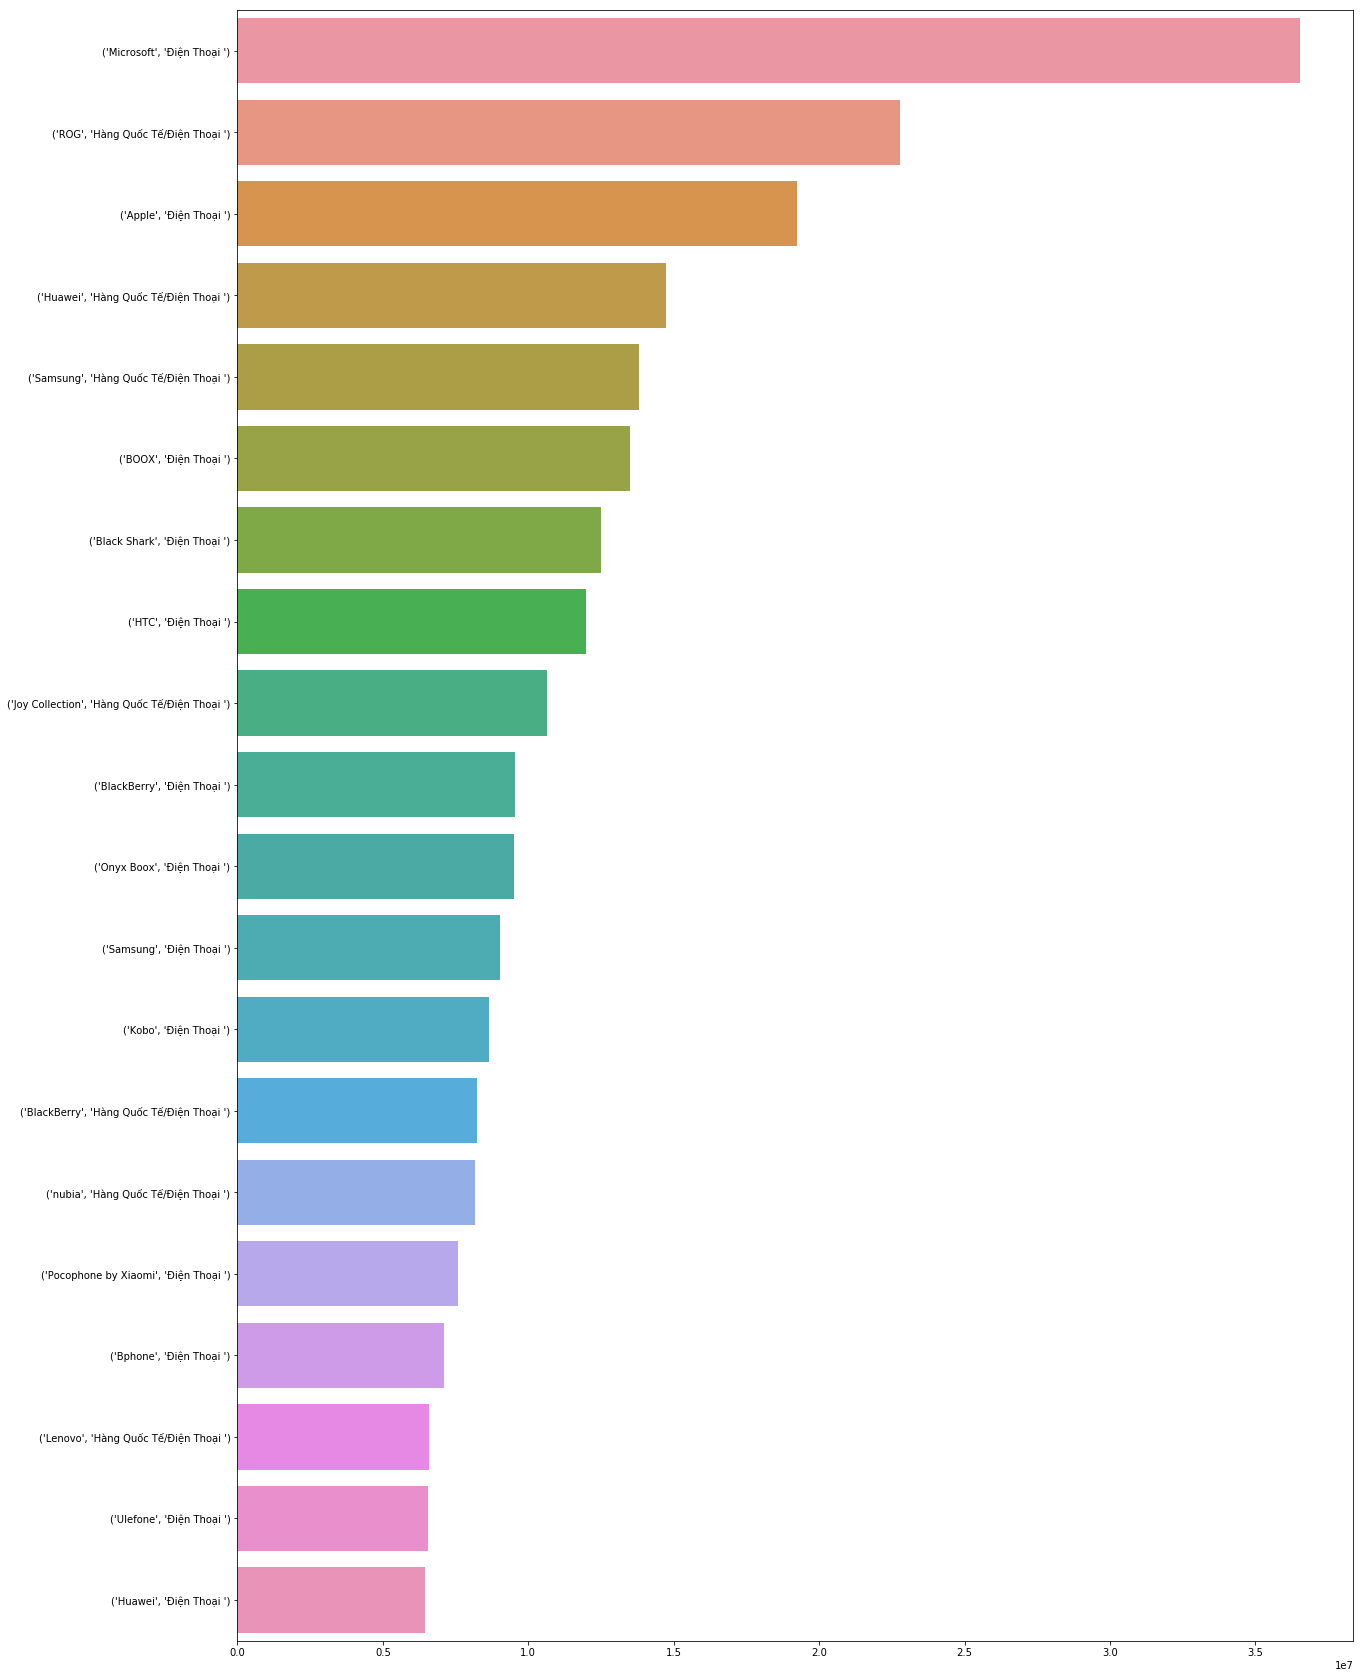

In [12]:
dienthoai = products[products["category"]=="Điện Thoại - Máy Tính Bảng"]
brand_price(dienthoai)

#### Which brand has the highest the rate of discount ?

In [13]:
def brand_discount(df):
    mean_price = df.groupby(["brand","subcategory"])["discount"].mean().sort_values(ascending=False).head(15)
    plt.figure(figsize=(20,10))
    sns.barplot(y = mean_price.index,x = mean_price.values)

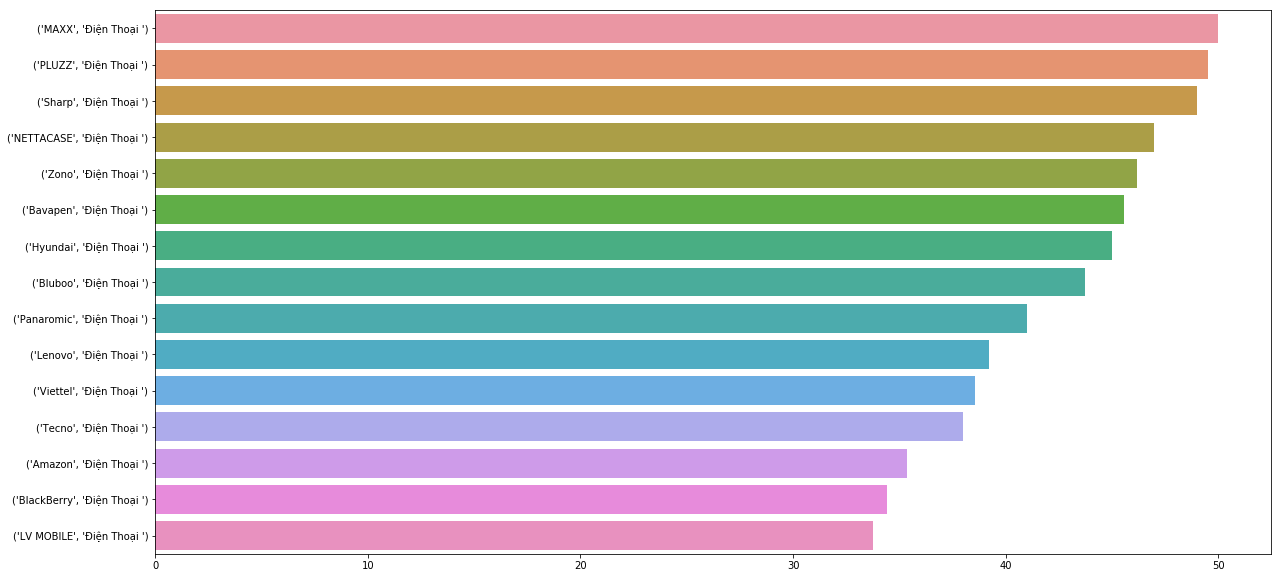

In [14]:
dienthoai = products[products["category"]=="Điện Thoại - Máy Tính Bảng"]
brand_discount(dienthoai)

#### The relationship between brand and tikinow feature

In [50]:
table_BTN = pd.crosstab(dienthoai["brand"],dienthoai["tikinow"])
table_BTN


tikinow,0,1
brand,,
Xiaomi,108,10


In [58]:
brand_minimum_tikinow = table_BTN[table_BTN[0] == table_BTN[0].max()]
brand_maximum_tikinow = table_BTN[table_BTN[1] == table_BTN[1].max()]
print(brand_minimum_tikinow)
print(brand_maximum_tikinow)

tikinow    0   1
brand           
Xiaomi   108  10
tikinow   0   1
brand          
Apple    51  52


#### Is there a relationship bewteen brand and tikinow feature?

In [35]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [59]:
stat, p, dof, expected = chi2_contingency(table_BTN)
print("p =",p)
if p <= 0.05:
    print("There is a relationship between brand and tikinow")
else:
    # p is the probablity that when the null hypothesis is true, the statistical summary 
    # (such as the absolute value of the sample mean difference between two compared groups)
    # would be greater than or equal to the actual observed results.
    print("There is no relationship between brand and tikinow")

p = 7.440301518337827e-21
There is a relationship between brand and tikinow


<Figure size 3600x7200 with 0 Axes>

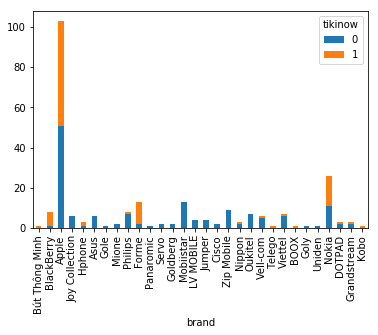

In [53]:
plt.figure(figsize=(50,100))
table_BTN.sample(30).plot.bar(stacked = True)

#### Is there a relationship between price and rating ? 

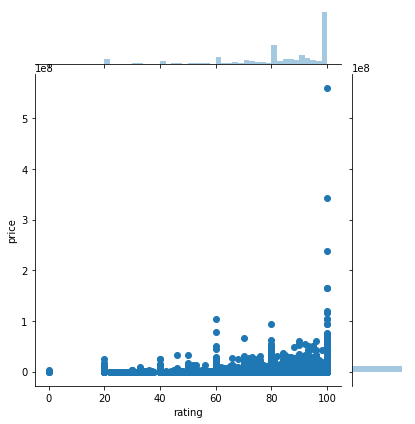

In [62]:
sns.jointplot(x=products['rating'],y=products['price'])

In [63]:
products[['rating','price']].corr()

,rating,price
rating,1.000000,0.035103
price,0.035103,1.000000
